### Define the WebGame Environment Class

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
#from gym import Env
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {"top": 200, "left": 0, "width": 800, "height": 500}  # Adjust as needed
        self.done_location = {"top": 235, "left": 230, "width": 560, "height": 60}  # Adjust as needed
        self.current_frame = None

    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])

        # Check if the game is over
        terminated, done_cap = self.get_done()
        truncated = False  # No time limit implemented, set truncated to False
        observation = self.get_observation()
        reward = 1  # Simple reward structure (adjust as needed)
        info = {}

        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        # Handle seeding
        if seed is not None:
            np.random.seed(seed)
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation(), {}

    def render(self):
        cv2.imshow("Game", self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    def close(self):
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        self.current_frame = raw
        plt.imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB))  # For debugging
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_cap_gray = cv2.cvtColor(done_cap, cv2.COLOR_BGR2GRAY)
        _, done_cap_thresh = cv2.threshold(done_cap_gray, 127, 255, cv2.THRESH_BINARY)
        done_strings = ["GAME", "GAHE"]
        res = pytesseract.image_to_string(done_cap_thresh)[:4]
        done = res in done_strings
        return done, done_cap_thresh

### Check Environment Compatibility
- the environment is checked for compatibility with Gym's standards using env_checker.check_env(). This is crucial for ensuring the environment works properly with reinforcement learning algorithms.

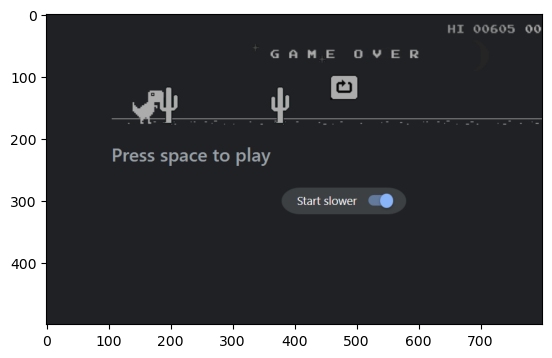

In [ ]:
env = WebGame()
obs = env.get_observation()

In [14]:
done, done_cap = env.get_done()

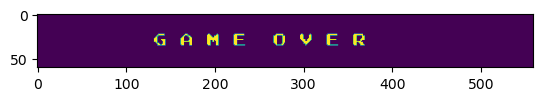

In [15]:
plt.imshow(done_cap)

In [16]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [17]:
done

True

### Train the model

#### Create callback

In [11]:
#from gym.spaces import Box, Discrete
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker


In [ ]:
env = WebGame()
env_checker.check_env(env)

In [13]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [14]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/' 

In [15]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)  

 #### Build DQN and Train

In [17]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack  

In [18]:
env = WebGame()

In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=None, verbose=1, buffer_size=1200000, learning_starts=1000)

In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
for episode in range(5):
    obs, _ = env.reset()  # Unpack observation from the tuple
    done = False
    total_reward = 0
    frames = []  # To store frames for video

    while not done:
        action, _ = model.predict(obs)  # Pass only the observation to predict()
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward 

        # Capture the current frame for the video
        frames.append(env.current_frame)
  
        time.sleep(0.01)
  
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

    # Save the gameplay as a video
    if episode < 5:  # Save the best 5 episodes
        video_path = f'gameplay_episode_{episode}.avi'
        height, width, layers = frames[0].shape
        video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
        for frame in frames:
            video.write(frame)
        video.release()
       
